# BRR Model for Query Rate Forecasting

Machine Learning skeleton model for predicting query rates on database management systems

## Dependencies

In [100]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from statsmodels.tsa.stattools import adfuller
from numpy import log
from sklearn.preprocessing import StandardScaler

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Import Dataset

In [101]:
# Generate example dataset
startDate = '2020-01-01'
endDate = '2024-01-01'
numDays = (pd.to_datetime(endDate) - pd.to_datetime(startDate)).days + 1

# Generate dates by day
dates = pd.date_range(start = startDate, end = endDate, freq = 'D')

# Generate random query rates
np.random.seed(0)  # For reproducibility
#queryRate = np.random.randint(0, 200, size = numDays)  # Random query rates between 0 and 200
normalizedQueryRate = np.random.normal(loc=100, scale=10, size=len(dates))  # Normalized set of query data

In [102]:
# Create a DataFrame
df = pd.DataFrame({'Date': dates, 'Query Rate': normalizedQueryRate})
df.set_index('Date', inplace = True)
df.head()

,Query Rate
Date,
2020-01-01,117.640523
2020-01-02,104.001572
2020-01-03,109.787380
2020-01-04,122.408932
2020-01-05,118.675580


## Clean and Preprocess Data

### Detecting Missing Values

In [103]:
# Fill in missing values
df = df.iloc[1:]
df = df.fillna(method='ffill')

# Alternatively drop missing values
# training = training.dropna(how='all')

### Detecting Outliers

In [104]:
# Calculate Z-score
z_scores = (df - df.mean()) / df.std()
threshold = 2
outliers = df[abs(z_scores) > threshold]

print("Z-Score Outliers:")
print()
print(outliers)

Z-Score Outliers:

            Query Rate
Date                  
2020-01-02         NaN
2020-01-03         NaN
2020-01-04  122.408932
2020-01-05         NaN
2020-01-06         NaN
...                ...
2023-12-28         NaN
2023-12-29         NaN
2023-12-30         NaN
2023-12-31         NaN
2024-01-01         NaN

[1461 rows x 1 columns]


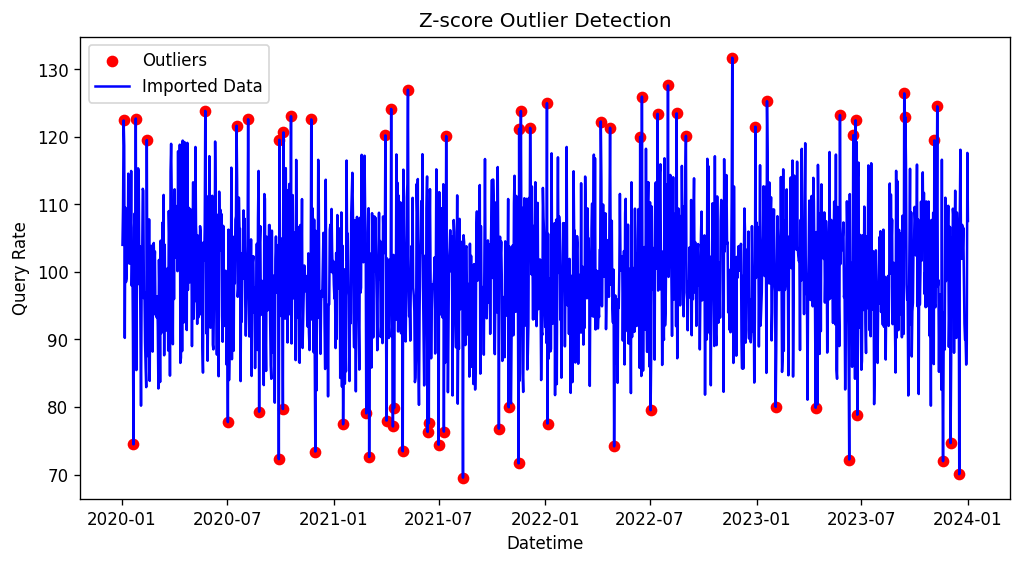

In [105]:
def showOutliers(df, outliers):
    # Highlight outliers graphically
    plt.figure(figsize=(10, 5))
    plt.scatter(outliers.index, outliers.values, color='red', label='Outliers')
    plt.plot(df, label='Imported Data', color='blue')
    
    plt.title('Z-score Outlier Detection')
    plt.xlabel('Datetime')
    plt.ylabel('Query Rate')
    plt.legend()
    plt.show()

showOutliers(df, outliers)

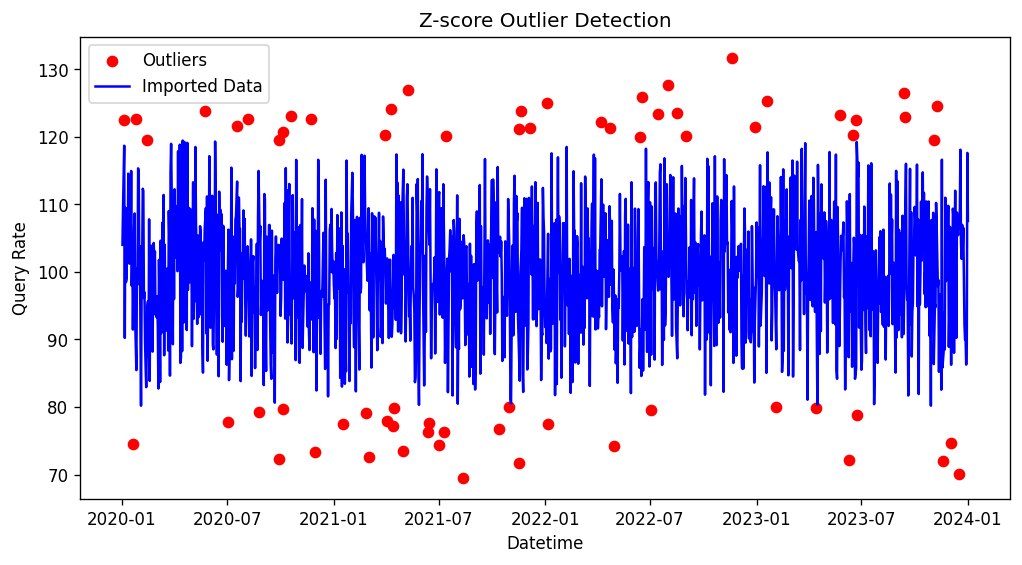

In [106]:
# Remove all outliers beyond the threshold standard deviations
df = df[(abs(z_scores) < threshold).all(axis=1)]

showOutliers(df, outliers)

### Hypothesis Testing - Checking Significance(p) Value

In [107]:
result = adfuller(df['Query Rate'].dropna())
# Check if p-value < significance value(0.05)
print('p-value: %f' % result[1])

p-value: 0.000000


In [108]:
# Creating Date Ranges for Specific Examinations if Desired
year2020 = pd.date_range(start = '1/1/2020', end = '1/1/2021', freq = 'M')
year2021 = pd.date_range(start = '1/1/2021', end = '1/1/2022', freq = 'M')

Note: Additional action can consider resampling through either upsampling or downsampling if further or less insight is desired for a specific time frame

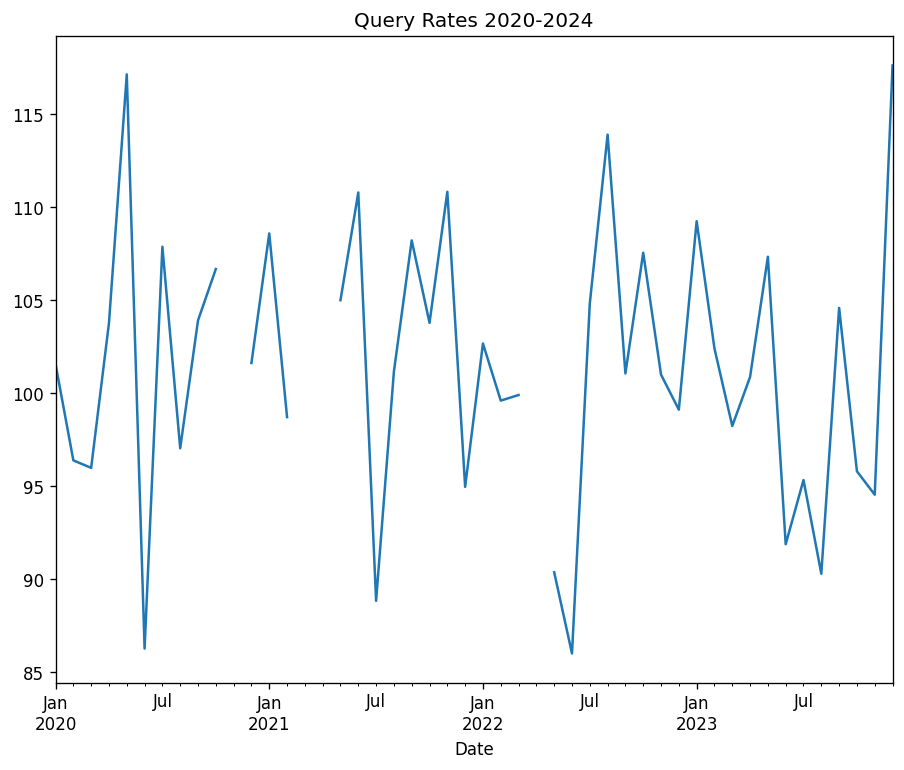

In [109]:
# Visualize Data
df['Query Rate'].asfreq('M').plot()
plt.title('Query Rates 2020-2024')
plt.show()

## Split into Training & Testing Datasets

In [110]:
# Split dataset into training and testing sets (80% training, 20% testing)
trainingData_Size = int(len(df) * 0.8)
training, testing = df[:trainingData_Size], df[trainingData_Size:]
# testing, validation = temp[:testing_size], temp[testing_size:]

# Print sizes of training and testing sets
print("Training set size:", len(training))
print("Testing set size:", len(testing))

Training set size: 1115
Testing set size: 279


In [111]:
# Prepare the feature matrix (x_training) and target vector (y_training) from the training set
x_training = np.arange(len(training)).reshape(-1, 1)  # Use the index as the feature
y_training = training['Query Rate']

x_testing = np.arange(len(testing)).reshape(-1, 1)  # Use the index as the feature
y_testing = testing['Query Rate']

In [112]:
# Standardize & scale features
#scaler = StandardScaler()
#x_trainingScaled = scaler.fit_transform(x_training)
#x_testingScaled = scaler.transform(x_testing)

## BRR Model

In [113]:
# Define the parameter grid to search over
param_grid = {
    'alpha_1': [1e-6, 1e-5, 1e-4, 1e-3],
    'lambda_1': [1e-6, 1e-5, 1e-4, 1e-3],
}

def gridSearch(param_grid):
    # Create a Bayesian Ridge Regression model
    brr = BayesianRidge()
    
    # Perform grid search with cross-validation
    grid_search = GridSearchCV(brr, param_grid, cv=5)
    grid_search.fit(x_training, y_training)
    
    # Get the best parameters and best score
    best_alpha = grid_search.best_params_['alpha_1']
    best_lambda = grid_search.best_params_['lambda_1']
    best_score = grid_search.best_score_
    
    print("Best alpha:", best_alpha)
    print("Best lambda:", best_lambda)
    print("Best score:", best_score)

gridSearch(param_grid)

Best alpha: 1e-06
Best lambda: 0.001
Best score: -0.023911690154603392


In [114]:
# Refine the parameter grid based on initial results
refined_param_grid = {
    'alpha_1': [best_alpha * 0.1, best_alpha, best_alpha * 10],
    'lambda_1': [best_lambda * 0.1, best_lambda, best_lambda * 10],
}

gridSearch(refined_param_grid)

Best alpha: 1e-07
Best lambda: 0.01
Best score: -0.023838573901894387


In [115]:
brr_model = BayesianRidge(alpha_1=best_alpha, lambda_1=best_lambda)
brr_model.fit(x_training, y_training)

BayesianRidge(lambda_1=0.001)

## Evaluate Model Performance

In [116]:
score = brr_model.score(x_training, y_training)
print("Model Score (R^2):", score)

Model Score (R^2): 0.0003157971805255455


In [117]:
y_prediction = brr_model.predict(x_training)

# Compare actual and predicted values
actual_versus_predicted = pd.DataFrame({'Actual': y_training, 'Predicted': y_prediction})

# Print the DataFrame
print(actual_versus_predicted)

                Actual  Predicted
Date                             
2020-01-02  104.001572  99.431420
2020-01-03  109.787380  99.431812
2020-01-05  118.675580  99.432203
2020-01-06   90.227221  99.432595
2020-01-07  109.500884  99.432987
...                ...        ...
2023-03-11  103.270662  99.866134
2023-03-12  116.315974  99.866526
2023-03-13  103.777592  99.866917
2023-03-14  102.398671  99.867309
2023-03-15  101.589587  99.867700

[1115 rows x 2 columns]


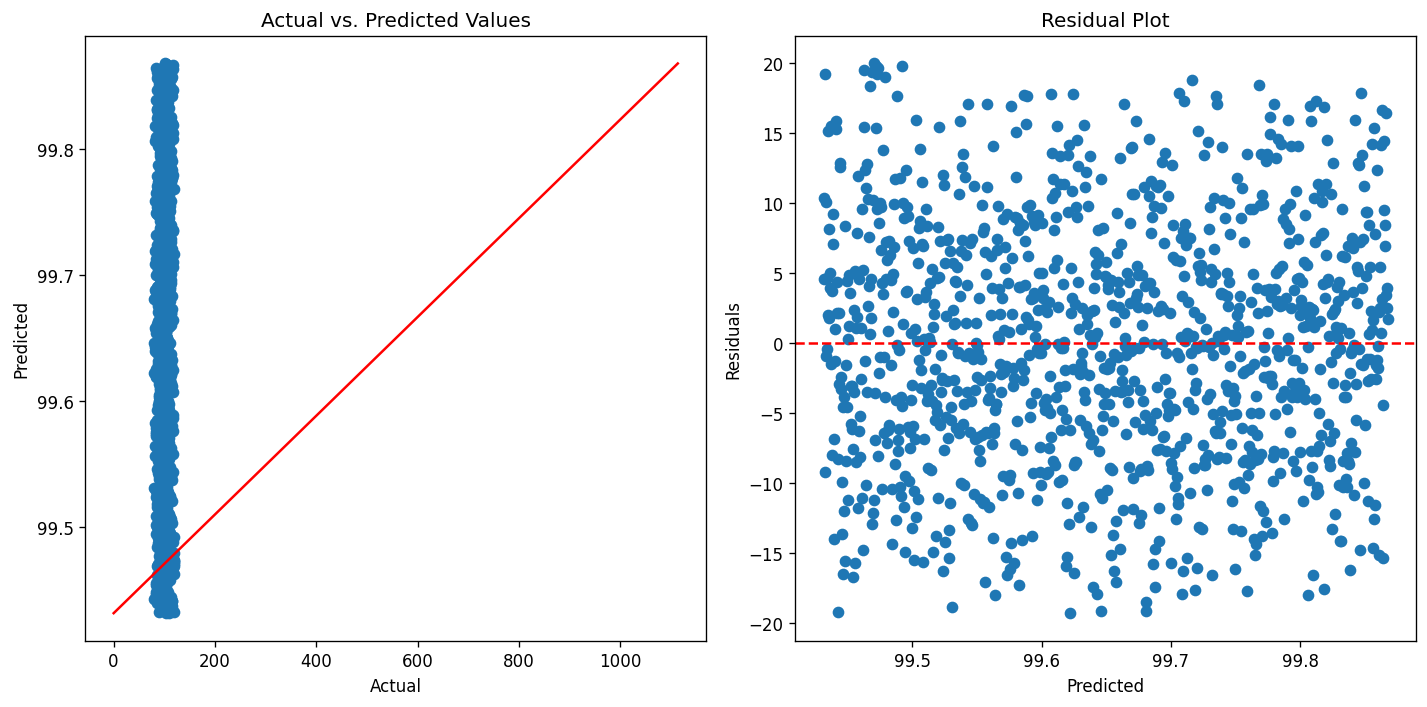

In [118]:
# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot of actual vs. predicted values
axs[0].scatter(y_training, y_prediction)
axs[0].plot(x_training, y_prediction, color='red', label='Predicted')
axs[0].set_xlabel("Actual")
axs[0].set_ylabel("Predicted")
axs[0].set_title("Actual vs. Predicted Values")

# Residual plot
residuals = y_training - y_prediction
axs[1].scatter(y_prediction, residuals)
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("Residuals")
axs[1].axhline(y=0, color='red', linestyle='--')
axs[1].set_title("Residual Plot")

plt.tight_layout()
plt.show()

To summarize, the following BRR skeleton follows the procedures of:
1. Importing Data
2. Data Preprocessing/Cleaning
3. Splitting Data into Training & Testing
5. Fitting into BRR Training Dataset
6. Fine Tune Training Model
7. Evaluate Testing Model Performance

In this case, sufficient data wasn't gathered so an example dataset was randomly generated. However, the skeleton exemplifies a basic outline on common practices.